In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install contractions
!pip install demoji
!pip install scikeras

     |████████████████████████████████| 321 kB 4.9 MB/s 
     |████████████████████████████████| 284 kB 58.2 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85446 sha256=fce05ab38f0ea11fc2b4a487f7ddeffbbabc7f7ee18c53cec68766ce66a70046
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick
     |████████████████████████████████| 42 kB 971 kB/s 
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.10.0
    Uninstalling importlib-metadata-4.10.0:
      Successfully uninstalled importlib-metadata-4.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 3.10.1 which is incompatible.


In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
TRAIN_PATH = "/content/drive/MyDrive/EDA/data/Corona_NLP_train.csv"

In [22]:
import numpy as np
import pandas as pd
import nltk
import contractions
import demoji
import string
from sklearn.metrics import accuracy_score
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

STOP_WORDS = stopwords.words('english')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Read dataset as csv

In [6]:
train_df = pd.read_csv(TRAIN_PATH, encoding="latin_1")
train_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [7]:
def reduce_sentiments(label: str):
  #Convert each sentiment that contains 'Extremely' to the shorter version
  #This way, Extremely Positive or Negative will be converted to Positive and 
  #Negative respectively 
  return label.split()[-1] if label.startswith('Extremely') else label

def convert_sentiment(sentiment):
  #Encode the sentiment to an integer label
    if sentiment == "Positive":
        return 2
    elif sentiment == "Negative":
        return 0
    return 1

train_df['Sentiment'] = train_df['Sentiment'].apply(reduce_sentiments)


train_df['SentimentCode'] = train_df['Sentiment'].apply(convert_sentiment)
train_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,SentimentCode
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,1
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,2
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,2
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,2
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Negative,0
...,...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral,1
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Negative,0
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive,2
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral,1


##Text Preprocessing

In [8]:
def rm_mentions(text):
  # Remove mentions such as @Username
    return  re.sub(r'@\w+','',text)
    
def rm_hashtags(text):
  # Remove hashtags
    return re.sub(r'#\w+','' , text)

def rm_hyperlinks(text):
  # Remove all hyperlinks in the tweets such as https://...
    return re.sub(r'http\S+', '', text)
def rm_html(text):
  # Remove html tags
    return re.sub('r<.*?>','', text)

def rm_emoji(text):
  # Remove emoji symbols using demoji library
  return demoji.replace(text)

def uncontract(text):
  # Transform common English contractions such as "won't" to "will not"
  return " ".join([contractions.fix(word) for word in text.split()])

def rm_digits(text):
  # Remove the digits
  return re.sub(r'\d+', '', text)

def rm_punkt(text):
  # Remove punctuation signs, such that words separated by a '/' denoting
  # Conjunctions will be split in 2 words instead of being merget together
  words = []
  for word in text.split():
    res = []
    for chr in word:
      if chr == '/':
        res.append(' ')
      elif chr not in string.punctuation:
        res.append(chr)
    words.append(''.join(res))
  return " ".join(words)
  
def clean_tweet(text, keep_stops=False):
  # Apply the above functions in one function and remove stopwords
  text = re.sub(r'â|Â',"\'", text)
  text = rm_mentions(text)
  text = rm_hashtags(text)
  text = rm_hyperlinks(text)
  text = rm_html(text)
  text = rm_emoji(text)
  text = rm_digits(text)
  text = uncontract(text)
  text = rm_punkt(text)
  if keep_stops:
    return " ".join([word.lower() for word in text.split() if word not in STOP_WORDS])
  return text.lower()
  

In [9]:
train_df['text'] = train_df['OriginalTweet'].apply(clean_tweet)
train_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,SentimentCode,text
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,1,and and
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,2,advice talk to your neighbours family to excha...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,2,coronavirus australia woolworths to give elder...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,2,my food stock is not the only one which is emp...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Negative,0,me ready to go at supermarket during the outbr...
...,...,...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral,1,airline pilots offering to stock supermarket s...
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Negative,0,response to complaint not provided citing covi...
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive,2,you know it is getting tough when is rationing...
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral,1,is it wrong that the smell of hand sanitizer i...


In [10]:
train_df['text_len'] = train_df['text'].apply(lambda x: len(x))


#Train-Test split

In [11]:
from sklearn.model_selection import train_test_split
X = train_df['text'].to_numpy()
#The actual labels will be the integer-encoded sentiments
y = train_df['SentimentCode'].to_numpy()

#Split the train set such that 90% will be used for training and 10% for validation 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(37041,)
(37041,)
(4116,)
(4116,)


#Build vocabulary

Build vocabulary and word-index mapping usin keras TextVectorization


In [12]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

seq_len = train_df['text_len'].max()

# The TextVectorization will build a vocabulary with at most 50_000 words
# And when passing a sentence Tensor, will ouptut a tensor of seq_len size
vectorizer = TextVectorization(max_tokens=50000,
                               output_sequence_length=seq_len)

text_dataset = tf.data.Dataset.from_tensor_slices(X_train).batch(128)
vectorizer.adapt(text_dataset)

In [13]:
vectorizer([["how are you doing "]])

<tf.Tensor: shape=(1, 286), dtype=int64, numpy=
array([[ 51,  10,  12, 180,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
   

In [14]:
#Compute a word-to-index dictionary with the learned words
word2idx = {word: index for index, word in enumerate(vectorizer.get_vocabulary())}

#Downlad GloVe embeddings and build embedding matrix

In [15]:
word2glove = {} 

with open("/content/drive/MyDrive/EDA/data/glove.twitter.27B.100d.txt") as f:
  for line in f:
    word, embeddings = line.split(maxsplit=1)
    coefs = np.fromstring(embeddings, "f", sep=" ")
    #Each word that is found in the txt file will be associated with its 
    #Word embedding
    word2glove[word] = coefs

Build the embedding matrix, i.e. for each word with index i in our word2idx dictionary, assign the i-th row in the embedding matrix to the words GloVe coefficient from word2glove

In [16]:
n_tokens = len(word2idx) + 2 #reserve 2 places for <PAD> and OOV 
embedding_size = 100 #as described by the dataset

#Assign
embedding_matrix = np.zeros((n_tokens, embedding_size))
for word, index in word2idx.items():
  #If the word is in the pre-trained GloVe dictionary
  if word in word2glove:
    #Use its index and assign the corresponding row with the embedding
    embedding_matrix[index] = word2glove[word]


X must be compliant to the Keras embedding layer, so we must vectorize it first. 

In [17]:
#The input for the keras' TextVectorizer must be of shape (TrainsetShape, 1)
X_train = vectorizer(np.array([[word] for word in X_train])).numpy()
X_val = vectorizer(np.array([[word] for word in X_val])).numpy()
print(f'Train set shape after vectorization: {X_train.shape}')
print(f'Validation set shape after vectorization: {X_val.shape}')

Train set shape after vectorization: (37041, 286)
Validation set shape after vectorization: (4116, 286)


In [18]:
from tensorflow.keras.utils import to_categorical
#In order to use the categorical crossentropy loss, y must be one-hot encoded
print(np.unique(y_train))
y_train_onehot = to_categorical(y_train)
y_val_onehot = to_categorical(y_val)

print(y_train_onehot[:10])

[0 1 2]
[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]


#Build the model

In [19]:
from keras.layers.core.dense import Dense
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from tensorflow import keras

# Initialize the embedding layer with the weights form the GloVe pre-trained 
# model
embedding_layer = Embedding(
    n_tokens,
    embedding_size,
    input_length=(None, X.shape[-1]),
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=True,
)

In [32]:
from tensorflow.keras import layers

def build_model(filters=128, 
                kernel_size=5,
                denses = [128],
                dropout = 0.5,
                lr = 1e-2):
  
  inputs = layers.Input(shape=(X_train.shape[-1]))
  x = embedding_layer(inputs)
  x = layers.Conv1D(filters, kernel_size, activation='relu')(x)
  x = layers.MaxPooling1D(pool_size=2)(x)
  x = layers.Flatten()(x)

  
  for size  in denses:
    x = layers.Dense(size, activation='relu')(x)
    if dropout > 0:
      x = layers.Dropout(dropout)(x)

  outs = layers.Dense(3, activation='softmax')(x)
  model = keras.Model(inputs, outs)
  
  model.compile(optimizer=keras.optimizers.Adam(lr),
                loss='categorical_crossentropy',
                metrics=['acc'])
  return model 

model = build_model()
model.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 286)]             0         
                                                                 
 embedding (Embedding)       (None, 286, 100)          3578900   
                                                                 
 conv1d_25 (Conv1D)          (None, 282, 128)          64128     
                                                                 
 max_pooling1d_25 (MaxPoolin  (None, 141, 128)         0         
 g1D)                                                            
                                                                 
 flatten_25 (Flatten)        (None, 18048)             0         
                                                                 
 dense_50 (Dense)            (None, 128)               2310272   
                                                          

In [21]:
import matplotlib.pyplot as plt
def plot_losses(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
  ax1.plot(history.history['loss'])
  ax1.plot(history.history['val_loss'])
  ax1.legend(['train', 'val'], loc='upper left')
  
  ax2.plot(history.history['acc'])
  ax2.plot(history.history['val_acc'])
  ax2.legend(['train', 'val'], loc='upper left')
  
  plt.show()

#Model selection methods
Perform hyperparameter tuning.

In [25]:
list_filters = [64]
list_kernel_size = [3, 4, 5]
list_denses = [[16], [32]]
list_dropout = [0.5]
list_lr = [1e-4, 1e-5]

for filters in list_filters:
  for kernel_size in list_kernel_size:
    for denses in list_denses:
      for dropout in list_dropout:
        for lr in list_lr:
          model = build_model(filters, kernel_size, denses, dropout, lr)
          history = model.fit(X_train, y_train_onehot, epochs = 20, batch_size=32,verbose=0,validation_data=(X_val, y_val_onehot))
          preds = model.predict(X_val, batch_size=32, verbose=0)
          preds = np.round(preds)
          acc = accuracy_score(np.argmax(preds, axis=1), np.argmax(y_val_onehot, axis=1))
          print("Filters: {}, Kernel size: {}, Denses: {}, Dropout: {}, Lr: {}, Val acc: {}".format(filters, kernel_size, denses, dropout, lr, acc))


Filters: 64, Kernel size: 3, Denses: [16], Dropout: 0.5, Lr: 0.0001, Val acc: 0.826773566569485
Filters: 64, Kernel size: 3, Denses: [16], Dropout: 0.5, Lr: 1e-05, Val acc: 0.8459669582118562
Filters: 64, Kernel size: 3, Denses: [32], Dropout: 0.5, Lr: 0.0001, Val acc: 0.8168124392614189
Filters: 64, Kernel size: 3, Denses: [32], Dropout: 0.5, Lr: 1e-05, Val acc: 0.8418367346938775
Filters: 64, Kernel size: 4, Denses: [16], Dropout: 0.5, Lr: 0.0001, Val acc: 0.8085519922254616
Filters: 64, Kernel size: 4, Denses: [16], Dropout: 0.5, Lr: 1e-05, Val acc: 0.8309037900874635
Filters: 64, Kernel size: 4, Denses: [32], Dropout: 0.5, Lr: 0.0001, Val acc: 0.8078231292517006
Filters: 64, Kernel size: 4, Denses: [32], Dropout: 0.5, Lr: 1e-05, Val acc: 0.8333333333333334
Filters: 64, Kernel size: 5, Denses: [16], Dropout: 0.5, Lr: 0.0001, Val acc: 0.8158406219630709
Filters: 64, Kernel size: 5, Denses: [16], Dropout: 0.5, Lr: 1e-05, Val acc: 0.8287172011661808
Filters: 64, Kernel size: 5, Denses:

In [47]:
#training the model with the best params 
cl_model = build_model(64, 3, [32], 0.5, 1e-5)
history = cl_model.fit(X_train, y_train_onehot, epochs = 20, batch_size=32,
                    verbose=0,
                    validation_data=(X_val, y_val_onehot))

#Performance on test data

In [48]:
TEST_PATH = '/content/drive/MyDrive/EDA/data/Corona_NLP_test.csv'

Load test dataset

In [49]:
test_df = pd.read_csv(TEST_PATH, encoding='latin_1')
test_df['Sentiment'] = test_df['Sentiment'].apply(reduce_sentiments)
test_df['SentimentCode'] = test_df['Sentiment'].apply(convert_sentiment)
test_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,SentimentCode
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Negative,0
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,2
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Positive,2
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative,0
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,1
...,...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive,2
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative,0
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral,1
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Negative,0


Clean test original tweets

In [50]:
test_df['text'] = test_df['OriginalTweet'].apply(clean_tweet)
test_df['text']

0       trending new yorkers encounter empty supermark...
1       when i could not find hand sanitizer at fred m...
2       find out how you can protect yourself and love...
3       buying hits city as anxious shoppers stock up ...
4       one week everyone buying baby milk powder the ...
                              ...                        
3793    meanwhile in a supermarket in israel  people d...
3794    did you panic buy a lot of nonperishable items...
3795    asst prof of economics was on talking about he...
3796    gov need to do something is instead of biar je...
3797    i and members are committed to the safety of o...
Name: text, Length: 3798, dtype: object

Vectorize test texts

In [51]:
X_test = test_df['text'].to_numpy()
y_test = test_df['SentimentCode'].to_numpy()

X_test = vectorizer([[sentence] for sentence in X_test]).numpy()
y_test = to_categorical(y_test)
print(X_test.shape)
print(y_test.shape)

(3798, 286)
(3798, 3)


Model performance

In [52]:
preds = cl_model.predict(X_test, batch_size=32, verbose=1)
preds = np.round(preds)

119/119 [==============================] - 0s 2ms/step


In [53]:
from sklearn.metrics import classification_report
cr = classification_report(preds, y_test)
print(cr)

              precision    recall  f1-score   support

           0       0.79      0.84      0.82      1522
           1       0.72      0.72      0.72       620
           2       0.83      0.81      0.82      1587

   micro avg       0.79      0.81      0.80      3729
   macro avg       0.78      0.79      0.78      3729
weighted avg       0.79      0.81      0.80      3729
 samples avg       0.79      0.79      0.79      3729



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
accuracy_score(np.argmax(preds, axis=1), np.argmax(y_test, axis=1))

0.8009478672985783

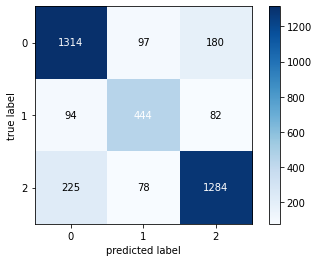

In [55]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

confm = confusion_matrix(np.argmax(preds, axis=1), np.argmax(y_test, axis=1))

figure, ax = plot_confusion_matrix(conf_mat = confm,
                                   colorbar = True)
plt.show()
